# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')


# b. MNIST Data Loader

In [2]:
def binarize_image(tensor):
    return (tensor > 0.5).float()

tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binarize_image)
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.78MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# **1. PixelCNN**


# a. Training Function

In [3]:
bce = F.binary_cross_entropy

def train(dataloader, model, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            tgt = images.clone()
            pred = model(images)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


# b. Masked Convolution

In [7]:
class MaskedConv2d(nn.Conv2d):
    ##################
    ### Problem 2(a): Implement MaskedConv2d
    def __init__(self, in_c, out_c, kernel_size, mask_type='A', **kwargs):
        super().__init__(in_c, out_c, kernel_size, **kwargs)

        kernel = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.register_buffer('mask', self.create_mask(kernel_size, mask_type))
        self.apply_mask()

    def create_mask(self, kernel_size, mask_type):
        height, width = kernel_size, kernel_size
        mask = torch.ones(self.weight.shape)

        h_center ,w_center = height // 2, width // 2
        for h in range(height):
            for w in range(width):
              if h > h_center:
                mask[:, :, h, w] = 0
              elif w > w_center:
                mask[:, :, h, w] = 0

              elif w == w_center and mask_type =='A':
                mask[:, :, h, w] = 0

        return mask

    def apply_mask(self):
        self.weight.data *= self.mask

    def forward(self, x):
        self.apply_mask()
        return super().forward(x)
    ##################


# c. Model

In [8]:
class PixelCNN(nn.Module):
    ##################
    ### Problem 2(b): Implement PixelCNN
     def __init__(self, input_channels=1, n_hidden=64, n_layers=8):
        super().__init__()

        # First layer with mask type 'A' to prevent seeing the current pixel
        self.first_conv = MaskedConv2d(
            in_c=input_channels,
            out_c=n_hidden,
            kernel_size=7,
            mask_type='A',
            padding=3
        )

        # Stack of hidden layers with mask type 'B'
        self.hidden_layers = nn.ModuleList([
            MaskedConv2d(
                in_c=n_hidden,
                out_c=n_hidden,
                kernel_size=3,
                mask_type='B',
                padding=1
            ) for _ in range(n_layers)
        ])

        self.batch_norms = nn.ModuleList([
            nn.BatchNorm2d(n_hidden) for _ in range(n_layers + 1)
        ])

        self.output_conv = MaskedConv2d(
            in_c=n_hidden,
            out_c=input_channels,  # Output matches input channels for reconstruction
            kernel_size=1,
            mask_type='B'
        )

        self.relu = nn.ReLU()

     def forward(self, x):

        x = self.first_conv(x)
        x = self.batch_norms[0](x)
        x = self.relu(x)

        # Hidden layers with residual connections
        for i, (conv, bn) in enumerate(zip(self.hidden_layers, self.batch_norms[1:])):
            residual = x
            x = conv(x)
            x = bn(x)
            x = self.relu(x)
            if i > 0:  # Skip first layer for residual
                x = x + residual

        x = self.output_conv(x)
        return torch.sigmoid(x)  # Sigmoid for binary pixel values
    ##################

# d. Training

In [9]:
##################
### Problem 2(c): Training

epochs = 100
model = PixelCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train(train_loader, model, optimizer, epochs)
##################


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [1/100], Average Loss: 0.1831



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [2/100], Average Loss: 0.1618



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [3/100], Average Loss: 0.1594



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [4/100], Average Loss: 0.1581



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [5/100], Average Loss: 0.1572



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [6/100], Average Loss: 0.1566



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [7/100], Average Loss: 0.1561



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [8/100], Average Loss: 0.1557



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [9/100], Average Loss: 0.1553



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [10/100], Average Loss: 0.1551



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [11/100], Average Loss: 0.1548



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [12/100], Average Loss: 0.1545



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [13/100], Average Loss: 0.1544



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [14/100], Average Loss: 0.1541



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [15/100], Average Loss: 0.1539



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [16/100], Average Loss: 0.1538



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [17/100], Average Loss: 0.1536



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [18/100], Average Loss: 0.1535



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [19/100], Average Loss: 0.1533



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [20/100], Average Loss: 0.1533



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [21/100], Average Loss: 0.1532



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [22/100], Average Loss: 0.1530



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [23/100], Average Loss: 0.1529



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [24/100], Average Loss: 0.1528



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [25/100], Average Loss: 0.1527



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [26/100], Average Loss: 0.1526



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [27/100], Average Loss: 0.1525



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [28/100], Average Loss: 0.1524



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [29/100], Average Loss: 0.1524



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [30/100], Average Loss: 0.1523



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [31/100], Average Loss: 0.1522



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [32/100], Average Loss: 0.1522



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [33/100], Average Loss: 0.1521



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [34/100], Average Loss: 0.1520



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [35/100], Average Loss: 0.1519



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [36/100], Average Loss: 0.1519



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [37/100], Average Loss: 0.1518



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [38/100], Average Loss: 0.1518



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [39/100], Average Loss: 0.1517



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [40/100], Average Loss: 0.1517



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [41/100], Average Loss: 0.1516



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [42/100], Average Loss: 0.1516



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [43/100], Average Loss: 0.1515



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [44/100], Average Loss: 0.1515



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [45/100], Average Loss: 0.1514



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [46/100], Average Loss: 0.1514



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [47/100], Average Loss: 0.1513



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [48/100], Average Loss: 0.1513



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [49/100], Average Loss: 0.1513



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [50/100], Average Loss: 0.1512



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [51/100], Average Loss: 0.1511



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [52/100], Average Loss: 0.1511



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [53/100], Average Loss: 0.1511



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [54/100], Average Loss: 0.1511



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [55/100], Average Loss: 0.1510



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [56/100], Average Loss: 0.1509



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [57/100], Average Loss: 0.1509



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [58/100], Average Loss: 0.1509



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [59/100], Average Loss: 0.1509



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [60/100], Average Loss: 0.1508



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [61/100], Average Loss: 0.1508



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [62/100], Average Loss: 0.1508



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [63/100], Average Loss: 0.1507



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [64/100], Average Loss: 0.1507



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [65/100], Average Loss: 0.1506



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [66/100], Average Loss: 0.1506



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [67/100], Average Loss: 0.1506



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [68/100], Average Loss: 0.1506



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [69/100], Average Loss: 0.1505



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [70/100], Average Loss: 0.1505



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [71/100], Average Loss: 0.1505



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [72/100], Average Loss: 0.1504



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [73/100], Average Loss: 0.1504



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [74/100], Average Loss: 0.1504



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [75/100], Average Loss: 0.1504



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [76/100], Average Loss: 0.1503



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [77/100], Average Loss: 0.1503



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [78/100], Average Loss: 0.1503



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [79/100], Average Loss: 0.1503



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [80/100], Average Loss: 0.1502



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [81/100], Average Loss: 0.1502



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [82/100], Average Loss: 0.1502



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [83/100], Average Loss: 0.1502



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [84/100], Average Loss: 0.1501



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [85/100], Average Loss: 0.1501



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [86/100], Average Loss: 0.1501



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [87/100], Average Loss: 0.1501



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [88/100], Average Loss: 0.1501



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [89/100], Average Loss: 0.1500



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [90/100], Average Loss: 0.1500



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [91/100], Average Loss: 0.1500



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [92/100], Average Loss: 0.1500



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [93/100], Average Loss: 0.1500



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [94/100], Average Loss: 0.1500



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [95/100], Average Loss: 0.1499



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [96/100], Average Loss: 0.1499



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [97/100], Average Loss: 0.1499



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [98/100], Average Loss: 0.1499



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [99/100], Average Loss: 0.1498



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [100/100], Average Loss: 0.1498



# e. Evaluation (Reconstruction)

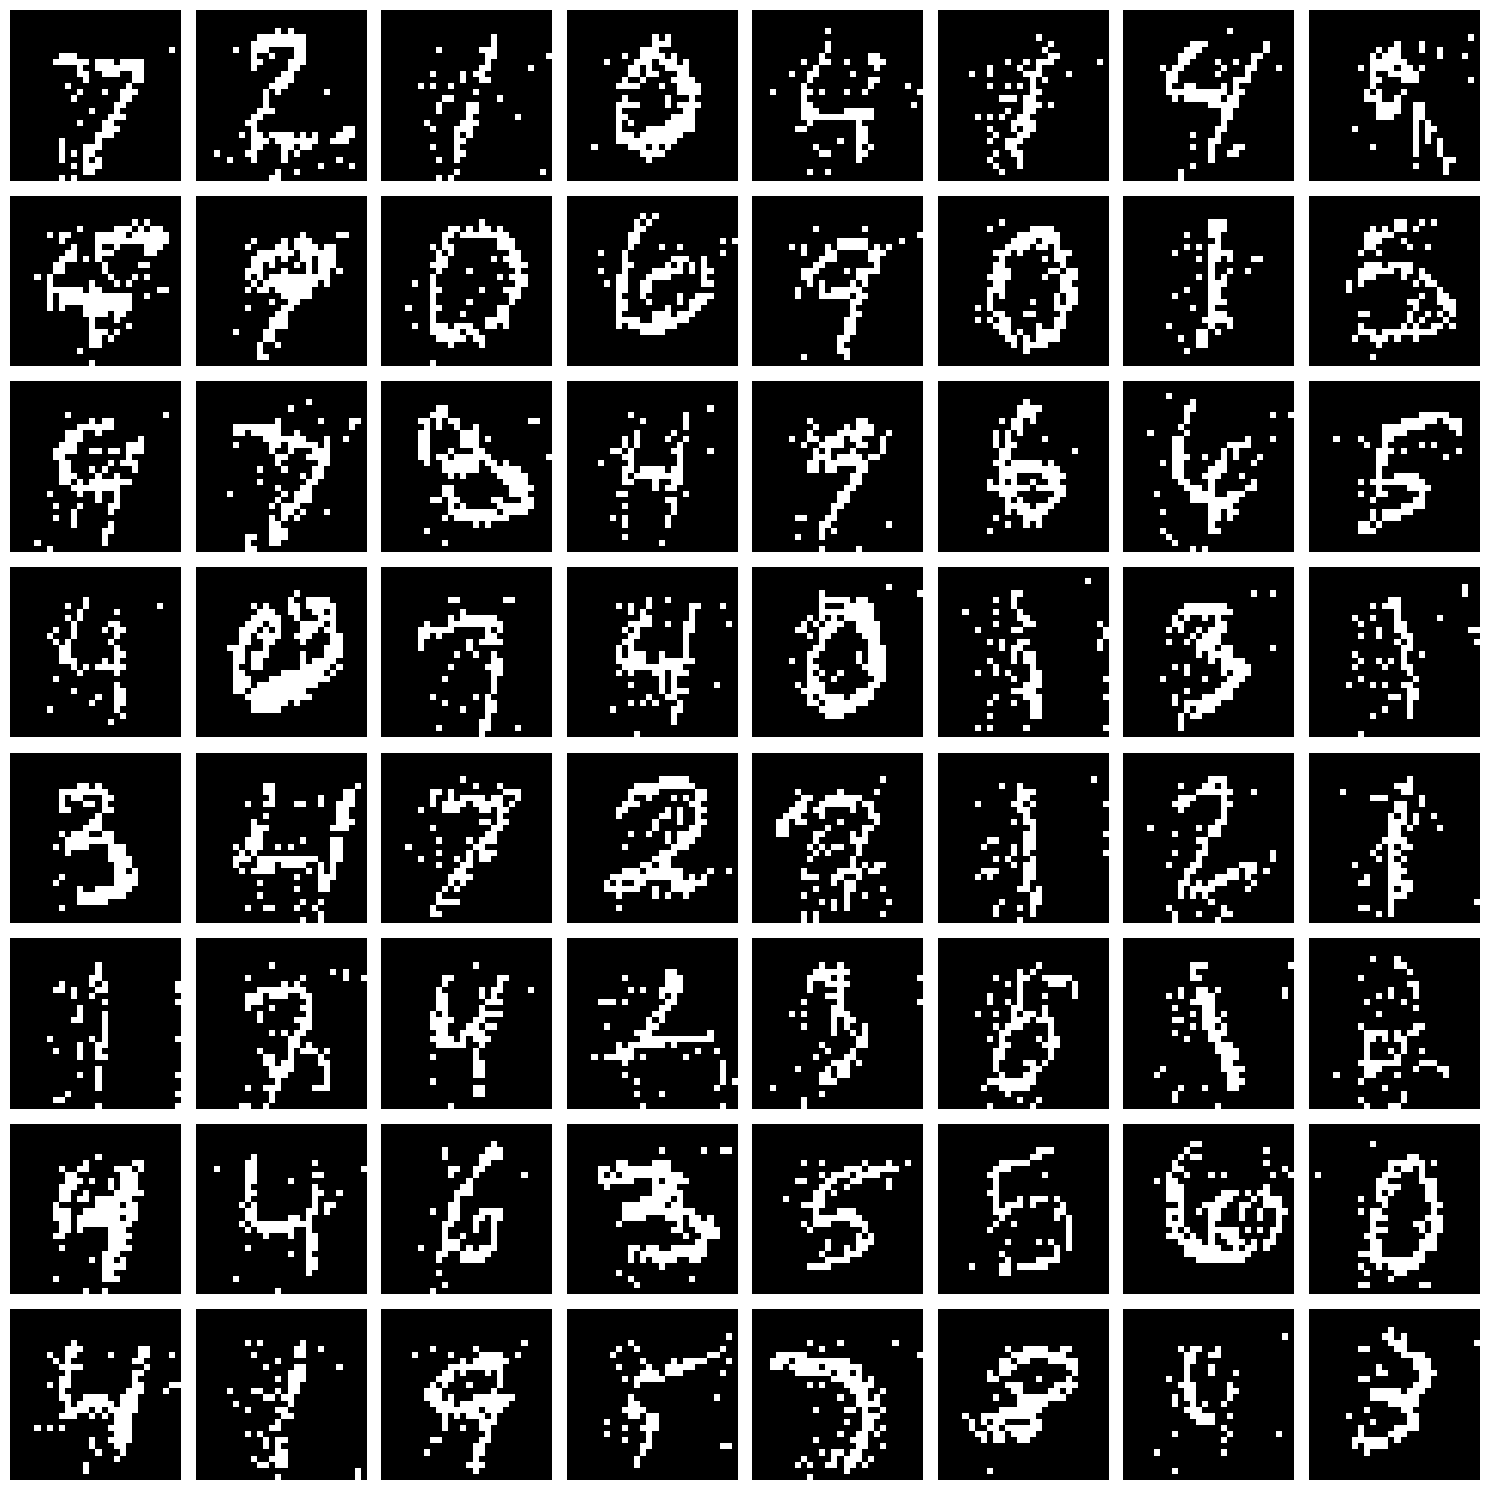

In [10]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      pred = model(images)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

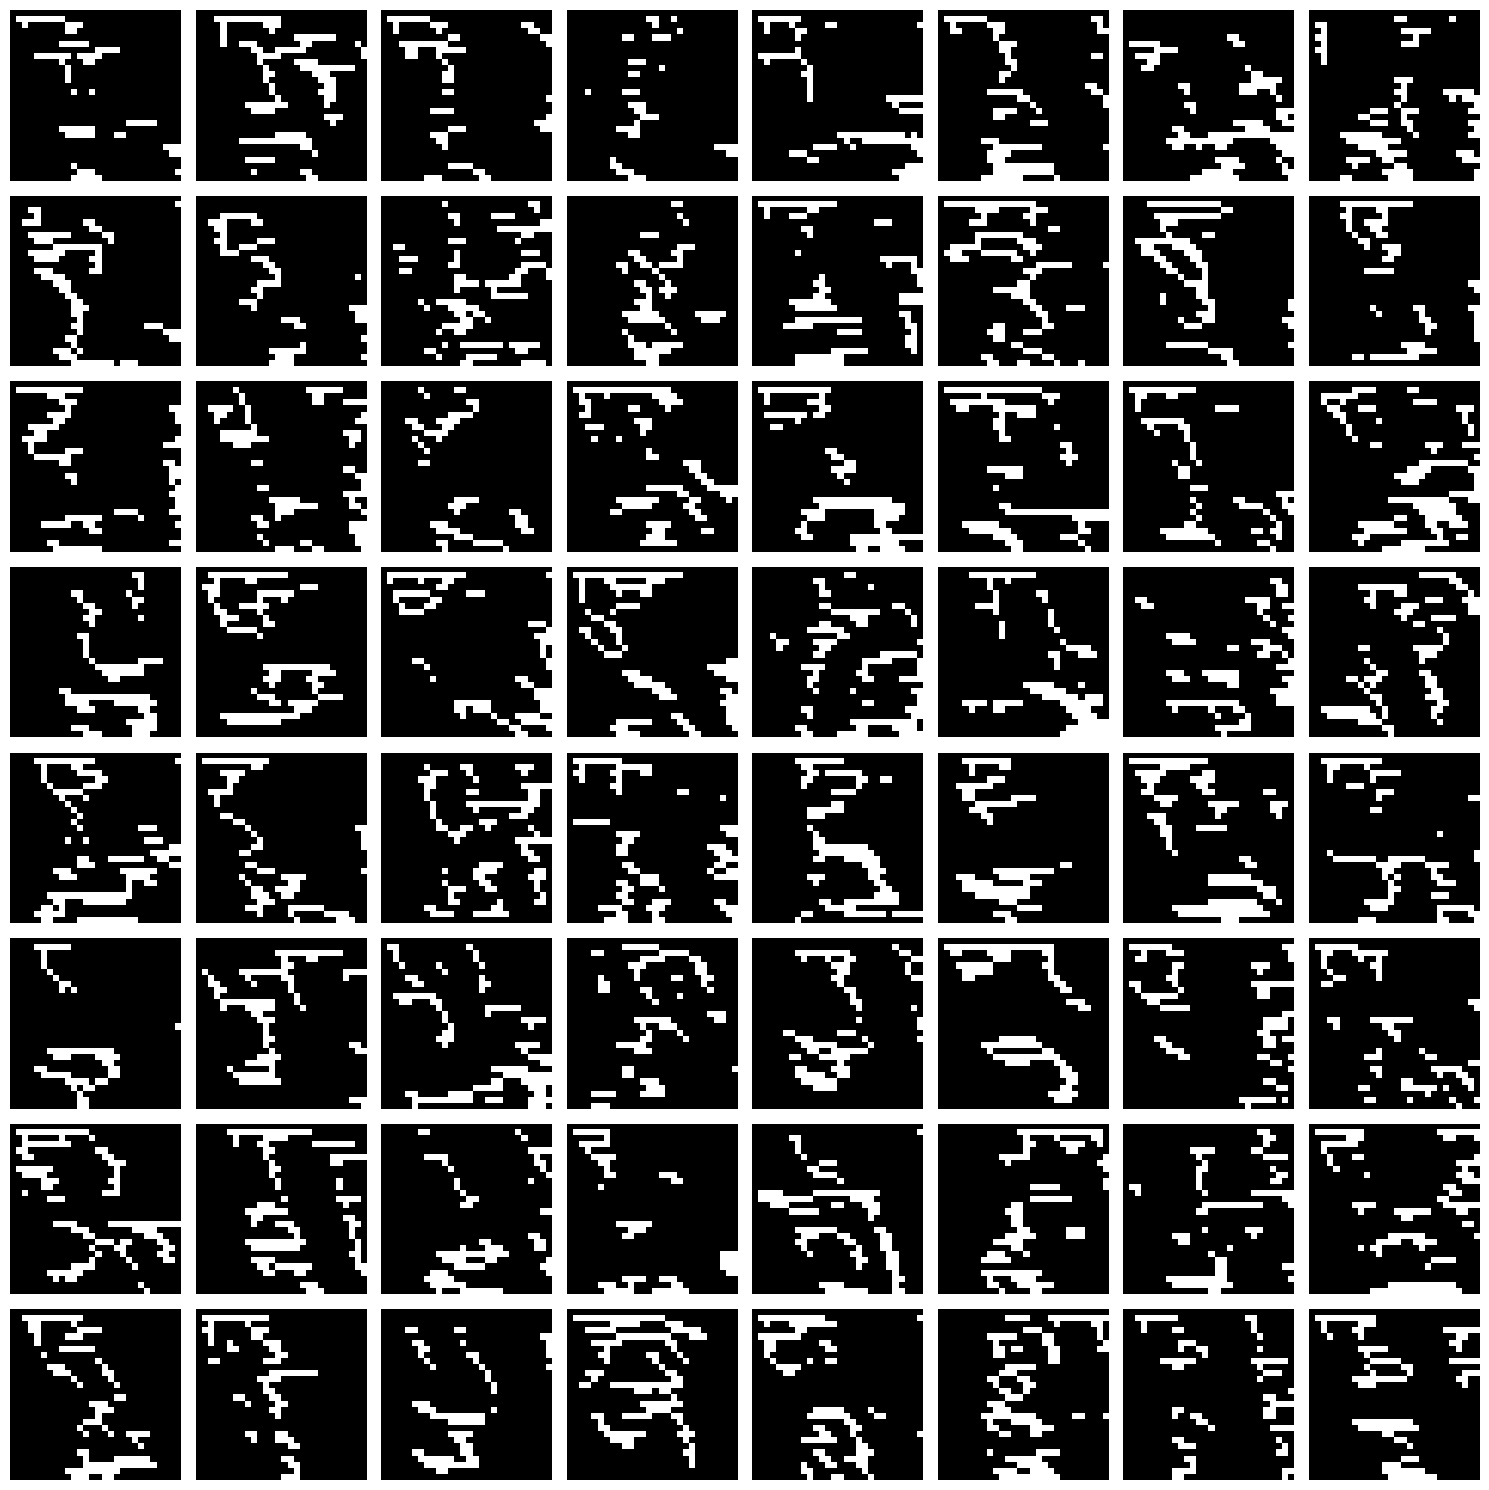

In [11]:
samples = torch.zeros(size=(64, 1, H, W)).to(device)
with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# **2. Conditional PixelCNN**


# a. Training Function

In [46]:
def train_cond(dataloader, model, optimizer, epochs, n_classes):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            labels = labels.to(device)
            tgt = images.clone()
            labels = F.one_hot(labels, num_classes=n_classes).float()
            pred = model(images, labels)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses

# b. Conditional Masked Convolution

In [66]:
class ConditionalMaskedConv2d(MaskedConv2d):
    ##################
    ### Problem 3(b): Implement ConditionalMaskedConv2d
    def __init__(self, in_channels, out_channels, kernel_size, num_classes, mask_type='A', **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, mask_type, **kwargs)

        self.num_classes = num_classes
        self.cond_bias = nn.Parameter(torch.randn(self.num_classes, out_channels) * 0.01) #bias for conditional
        self.conv_bias = nn.Parameter(torch.zeros(out_channels) * 0.01) #regular bias for convolution -> (out_channels)



    def forward(self, x, class_condition):
      masked_conv = super().forward(x)
      biased_conv = masked_conv + self.conv_bias.view(1, -1, 1, 1) #out_channels -> (1, out_channels, 1, 1)
      conditional_bias = torch.matmul(class_condition, self.cond_bias) #class_condition -> (batch_size, num_classes) | self.bias -> (num_classes, out_channels) | output -> (batch_size, out_channels)
      conditional_bias = conditional_bias.unsqueeze(-1).unsqueeze(-1) # (batch_size, out_channels) -> (batch_size, out_channels, 1, 1), broadcasting over spatial dimensions
      return biased_conv + conditional_bias

    ##################

# c. Model

In [67]:
class ConditionalPixelCNN(nn.Module):
    ##################
    ### Problem 3(b): Implement ConditionalPixelCNN
       def __init__(self, num_classes, input_channels=1, hidden_channels=64, num_layers=8):
        super().__init__()

        # First layer uses mask type 'A' to prevent seeing current pixel
        self.first_conv = ConditionalMaskedConv2d(
            in_channels=input_channels,
            out_channels=hidden_channels,
            kernel_size=7,
            num_classes = num_classes,
            mask_type='A',
            padding=3
        )

        self.hidden_layers = nn.ModuleList([
            ConditionalMaskedConv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                num_classes=num_classes,
                mask_type='B',
                padding=1
            ) for _ in range(num_layers)
        ])

        self.batch_norms = nn.ModuleList([
            nn.BatchNorm2d(hidden_channels)
            for _ in range(num_layers + 1)
        ])

        self.relu = nn.ReLU()

        self.output_conv = ConditionalMaskedConv2d(
            in_channels=hidden_channels,
            out_channels=input_channels,
            kernel_size=1,  # 1x1 convolution for final prediction
            num_classes=num_classes,
            mask_type='B'
        )

       def forward(self, x, class_condition):

        x = self.first_conv(x, class_condition)
        x = self.batch_norms[0](x)
        x = self.relu(x)

        for i, (conv, bn) in enumerate(zip(self.hidden_layers, self.batch_norms[1:])):
            residual = x

            x = conv(x, class_condition)
            x = bn(x)
            x = self.relu(x)

            if i > 0:
                x = x + residual

        x = self.output_conv(x, class_condition)

        return torch.sigmoid(x)
    ##################

# d. Training

In [68]:
##################
epochs = 100
### Problem 3(c): Training
n_classes = 10
model = ConditionalPixelCNN(num_classes=n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train_cond(train_loader, model, optimizer, epochs, n_classes)
##################


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [1/100], Average Loss: 0.1766



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [2/100], Average Loss: 0.1512



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [3/100], Average Loss: 0.1477



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [4/100], Average Loss: 0.1458



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [5/100], Average Loss: 0.1448



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [6/100], Average Loss: 0.1439



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [7/100], Average Loss: 0.1433



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [8/100], Average Loss: 0.1429



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [9/100], Average Loss: 0.1424



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [10/100], Average Loss: 0.1421



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [11/100], Average Loss: 0.1418



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [12/100], Average Loss: 0.1416



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [13/100], Average Loss: 0.1414



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [14/100], Average Loss: 0.1411



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [15/100], Average Loss: 0.1411



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [16/100], Average Loss: 0.1408



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [17/100], Average Loss: 0.1407



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [18/100], Average Loss: 0.1406



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [19/100], Average Loss: 0.1404



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [20/100], Average Loss: 0.1403



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [21/100], Average Loss: 0.1402



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [22/100], Average Loss: 0.1401



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [23/100], Average Loss: 0.1400



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [24/100], Average Loss: 0.1399



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [25/100], Average Loss: 0.1397



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [26/100], Average Loss: 0.1397



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [27/100], Average Loss: 0.1396



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [28/100], Average Loss: 0.1395



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [29/100], Average Loss: 0.1394



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [30/100], Average Loss: 0.1394



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [31/100], Average Loss: 0.1393



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [32/100], Average Loss: 0.1392



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [33/100], Average Loss: 0.1392



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [34/100], Average Loss: 0.1391



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [35/100], Average Loss: 0.1390



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [36/100], Average Loss: 0.1390



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [37/100], Average Loss: 0.1389



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [38/100], Average Loss: 0.1388



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [39/100], Average Loss: 0.1388



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [40/100], Average Loss: 0.1388



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [41/100], Average Loss: 0.1387



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [42/100], Average Loss: 0.1387



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [43/100], Average Loss: 0.1386



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [44/100], Average Loss: 0.1386



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [45/100], Average Loss: 0.1385



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [46/100], Average Loss: 0.1385



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [47/100], Average Loss: 0.1384



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [48/100], Average Loss: 0.1384



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [49/100], Average Loss: 0.1383



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [50/100], Average Loss: 0.1383



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [51/100], Average Loss: 0.1383



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [52/100], Average Loss: 0.1382



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [53/100], Average Loss: 0.1382



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [54/100], Average Loss: 0.1382



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [55/100], Average Loss: 0.1381



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [56/100], Average Loss: 0.1381



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [57/100], Average Loss: 0.1380



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [58/100], Average Loss: 0.1380



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [59/100], Average Loss: 0.1380



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [60/100], Average Loss: 0.1379



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [61/100], Average Loss: 0.1379



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [62/100], Average Loss: 0.1379



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [63/100], Average Loss: 0.1378



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [64/100], Average Loss: 0.1378



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [65/100], Average Loss: 0.1378



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [66/100], Average Loss: 0.1378



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [67/100], Average Loss: 0.1377



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [68/100], Average Loss: 0.1377



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [69/100], Average Loss: 0.1376



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [70/100], Average Loss: 0.1376



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [71/100], Average Loss: 0.1376



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [72/100], Average Loss: 0.1375



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [73/100], Average Loss: 0.1376



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [74/100], Average Loss: 0.1375



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [75/100], Average Loss: 0.1375



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [76/100], Average Loss: 0.1375



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [77/100], Average Loss: 0.1374



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [78/100], Average Loss: 0.1374



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [79/100], Average Loss: 0.1374



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [80/100], Average Loss: 0.1374



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [81/100], Average Loss: 0.1373



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [82/100], Average Loss: 0.1373



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [83/100], Average Loss: 0.1373



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [84/100], Average Loss: 0.1372



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [85/100], Average Loss: 0.1372



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [86/100], Average Loss: 0.1372



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [87/100], Average Loss: 0.1372



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [88/100], Average Loss: 0.1371



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [89/100], Average Loss: 0.1371



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [90/100], Average Loss: 0.1372



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [91/100], Average Loss: 0.1371



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [92/100], Average Loss: 0.1371



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [93/100], Average Loss: 0.1371



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [94/100], Average Loss: 0.1370



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [95/100], Average Loss: 0.1370



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [96/100], Average Loss: 0.1370



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [97/100], Average Loss: 0.1370



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [98/100], Average Loss: 0.1370



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [99/100], Average Loss: 0.1369



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [100/100], Average Loss: 0.1369



# e. Evaluation (Reconstruction)

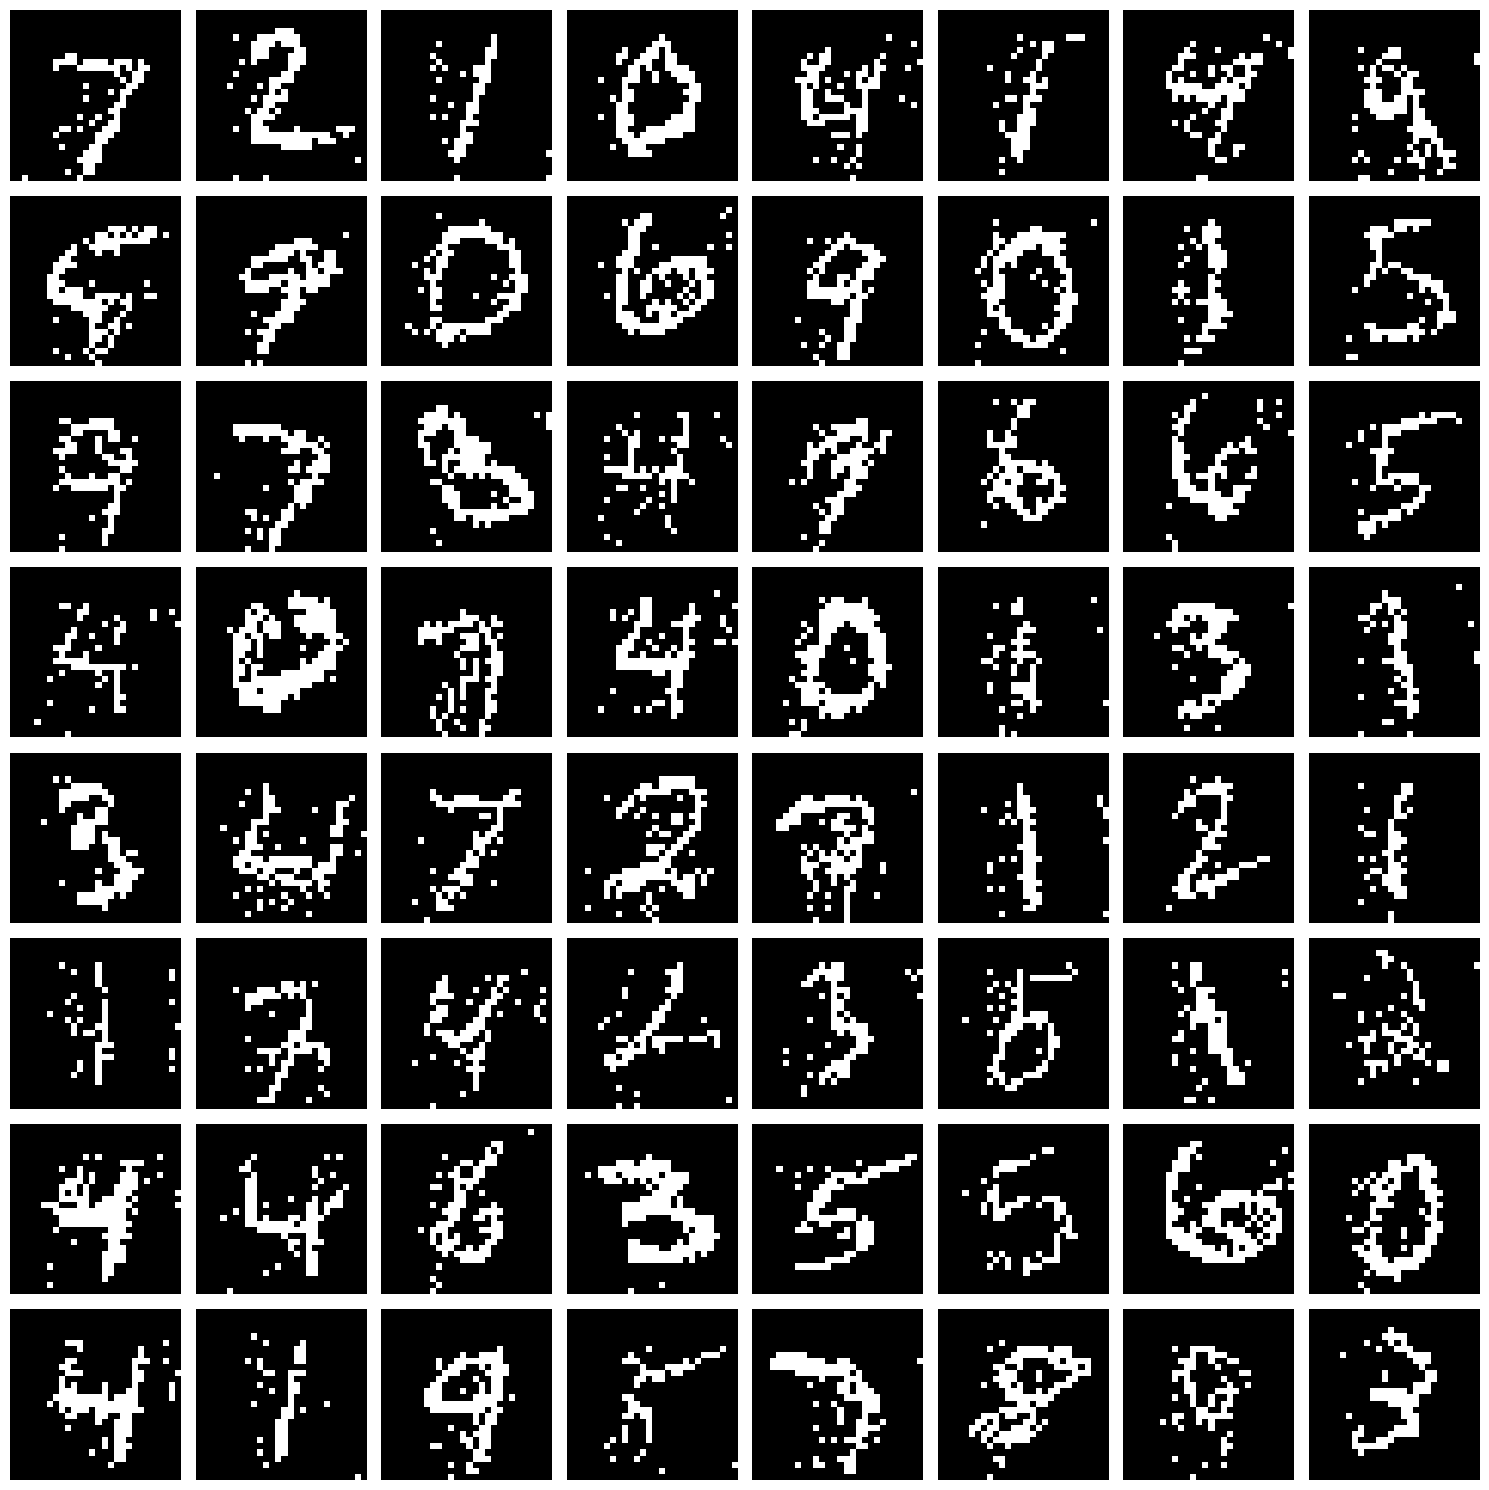

In [69]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)
      labels = F.one_hot(labels, num_classes=n_classes).float()
      pred = model(images, labels)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

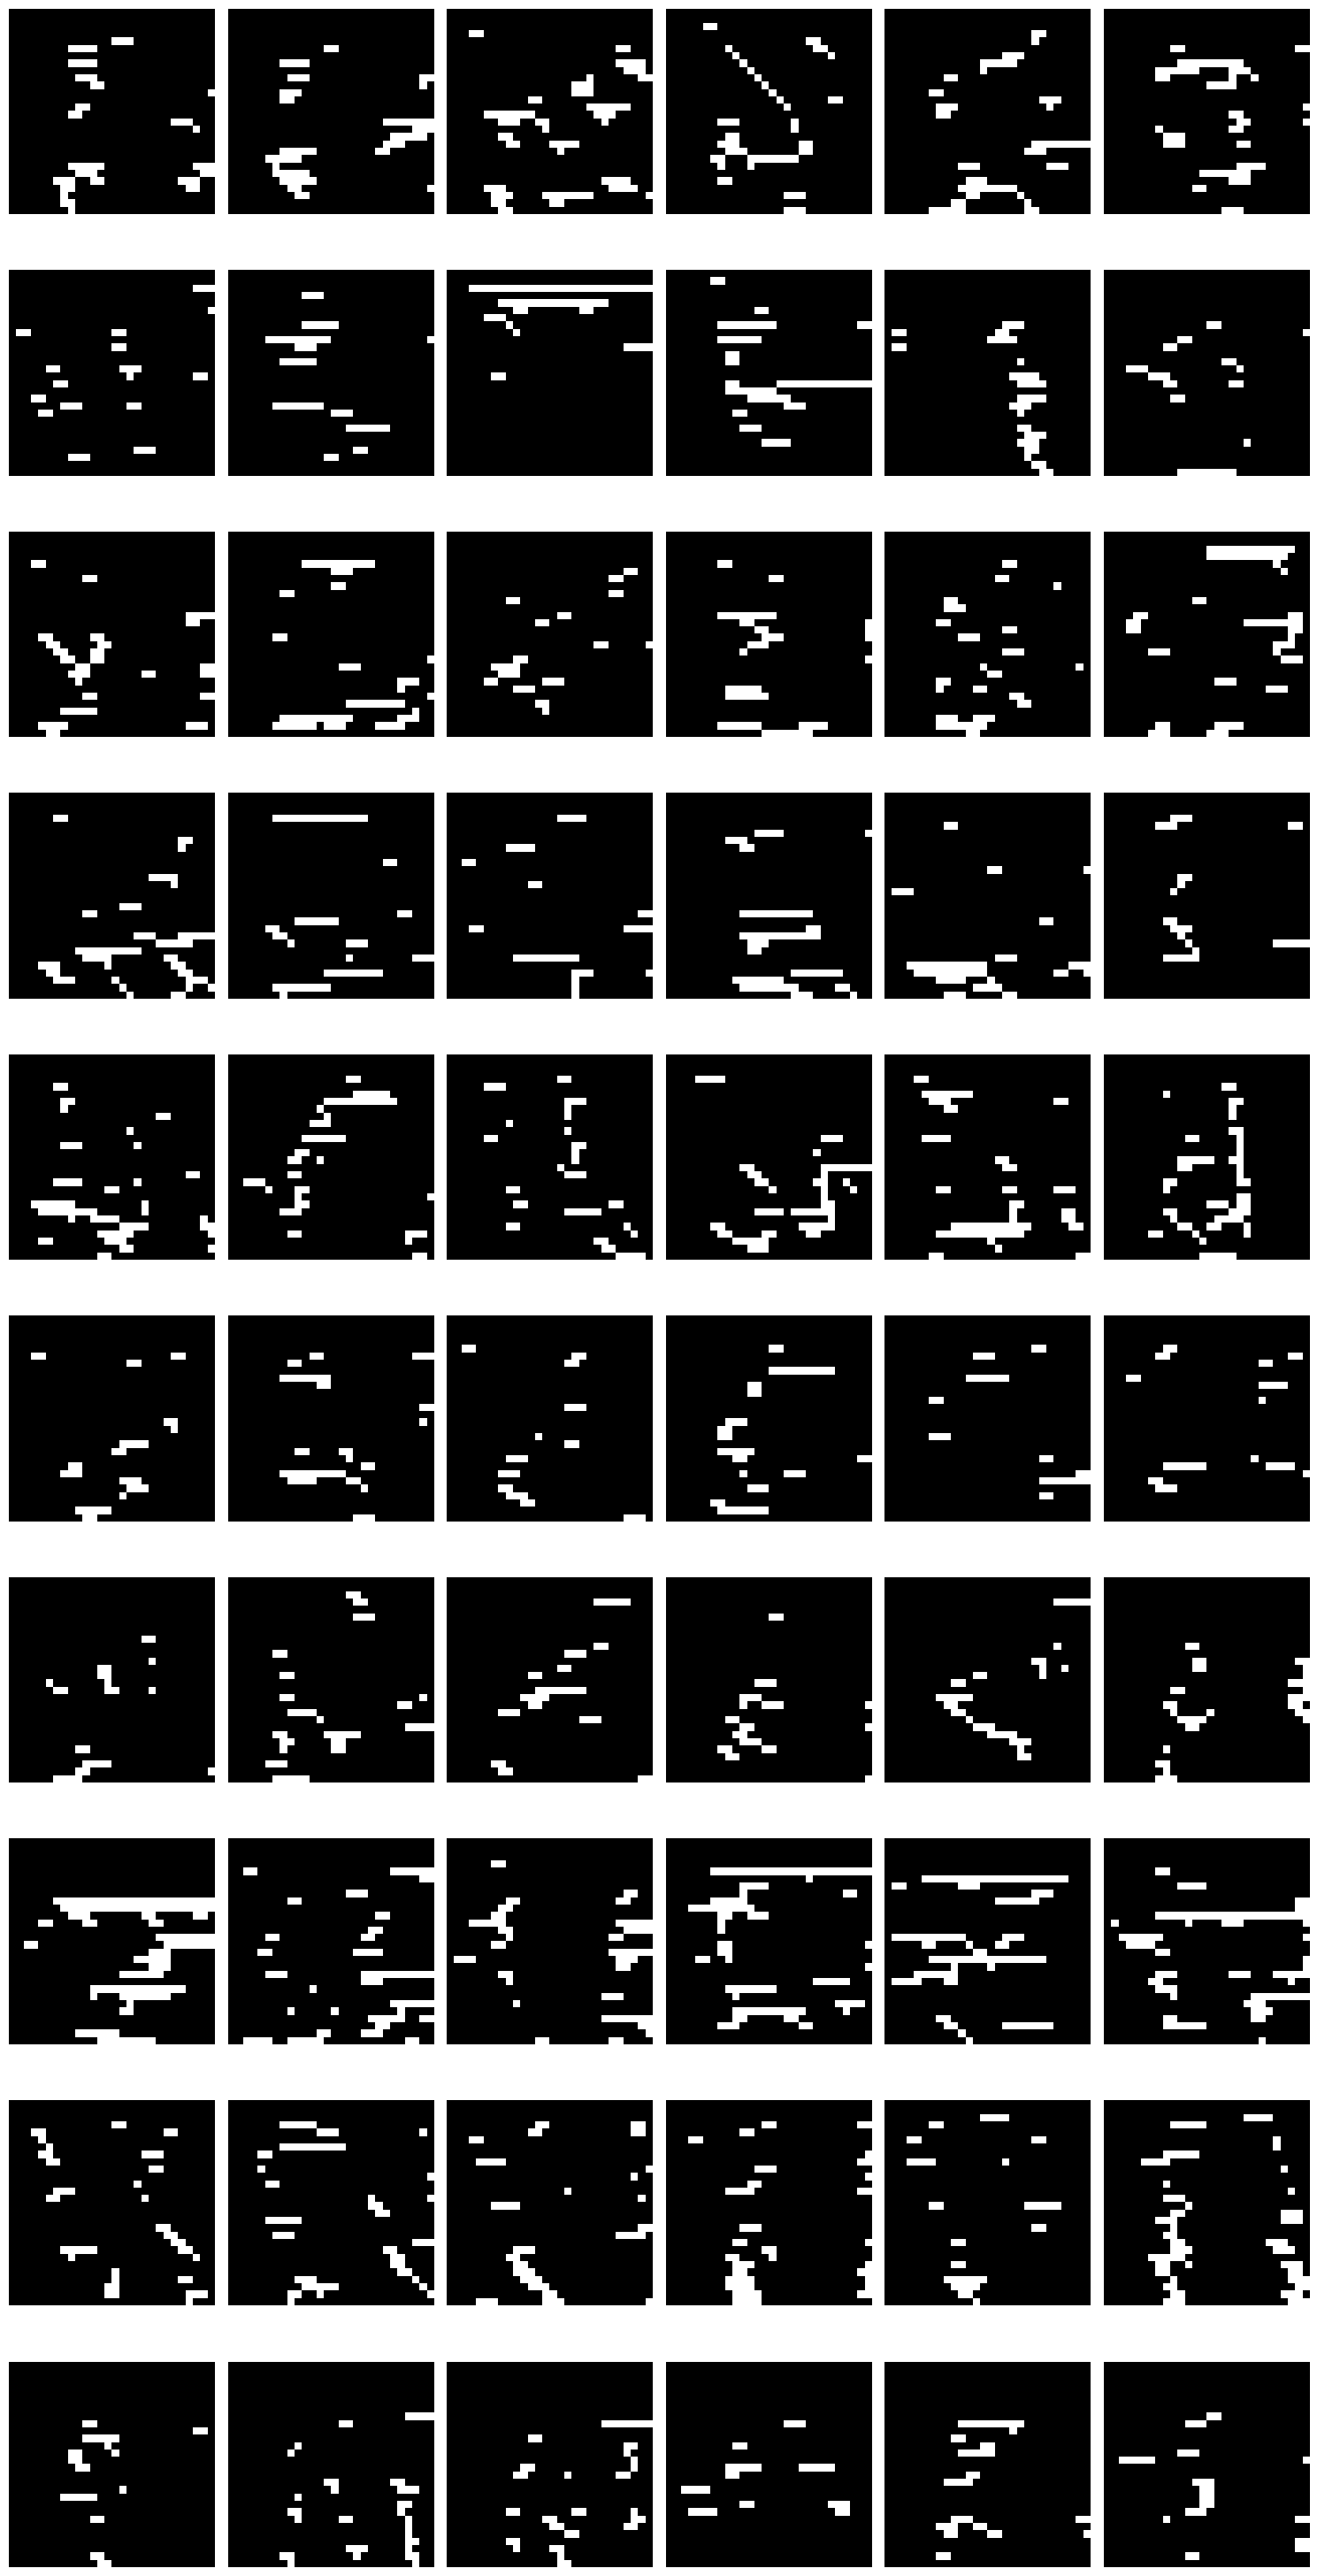

In [70]:
samples = torch.zeros(size=(60, 1, H, W)).to(device)
sample_classes = np.sort(np.array([np.arange(n_classes)] * 6).flatten())
sample_classes = F.one_hot(torch.tensor(sample_classes), num_classes=n_classes).to(device).float()

with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples, sample_classes)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(10, 6, figsize=(15, 30))

for i in range(60):
    sample = samples[i]
    row, col = divmod(i, 6)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()